In [ ]:
import pickle
import pandas as pd 

with open('spy5m.pkl', 'rb') as f:
    df = pickle.load(f)
df

,volume,vwap,open,close,high,low,transactions
timestamp,,,,,,,
2003-09-10 08:00:00-04:00,1000.0,102.8600,102.8600,102.8600,102.8600,102.86,1
2003-09-10 08:05:00-04:00,1600.0,102.8750,102.8600,102.9000,102.9000,102.86,4
2003-09-10 08:10:00-04:00,1300.0,102.8615,102.9000,102.8500,102.9000,102.85,2
2003-09-10 08:20:00-04:00,100.0,102.8000,102.8000,102.8000,102.8000,102.80,1
2003-09-10 08:25:00-04:00,17900.0,102.7358,102.7200,102.7300,102.7700,102.72,5
...,...,...,...,...,...,...,...
2024-04-30 19:40:00-04:00,10401.0,500.9938,500.9101,501.0682,501.0682,500.91,93
2024-04-30 19:45:00-04:00,3686.0,501.1517,501.1200,501.1500,501.1800,501.11,62
2024-04-30 19:50:00-04:00,1952.0,501.0709,501.1500,500.9900,501.1500,500.99,56


In [ ]:
from pz_algorithm import pz_algorithm

peaks, troughs = pz_algorithm(df['close'], iterations=6)
print(f'Peaks: {len(peaks)}, Troughs: {len(troughs)}')

Peaks: 8, Troughs: 8


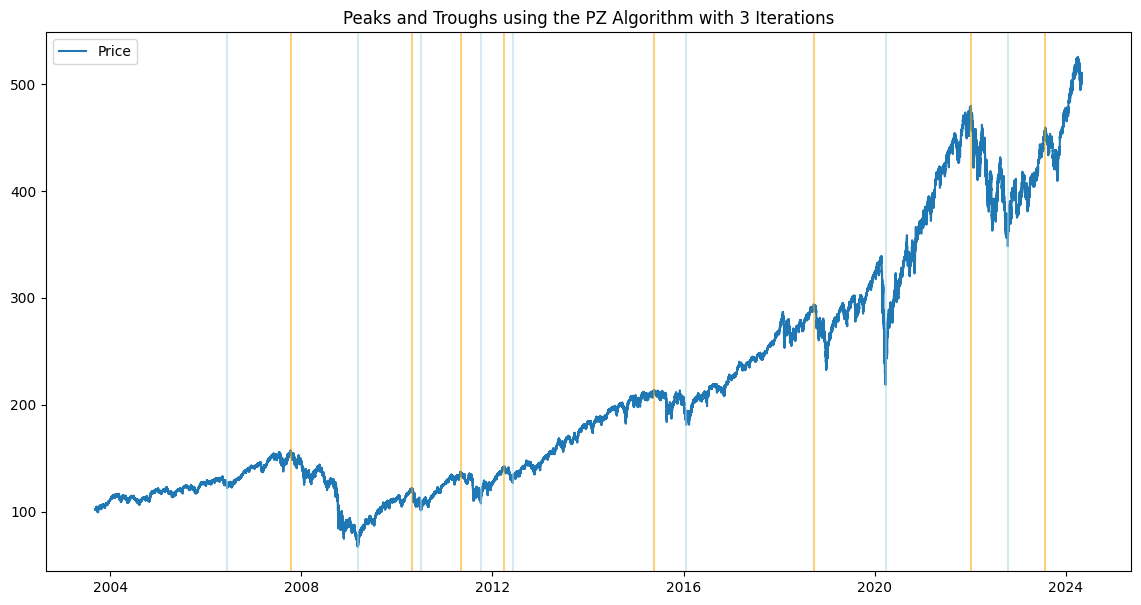

In [ ]:
# plot the peaks and troughs
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(df['close'], label='Price')
# use orange vertical lines for peaks and light blue vertical lines for troughs
for peak in peaks.index:
    plt.axvline(peak, color='orange', alpha=0.5)
for trough in troughs.index:
    plt.axvline(trough, color='lightblue', alpha=0.5)
plt.title('Peaks and Troughs using the PZ Algorithm with 6 Iterations')
plt.legend()
plt.show()


# Comparison to Binary Segmentation, CUSUM, PELT

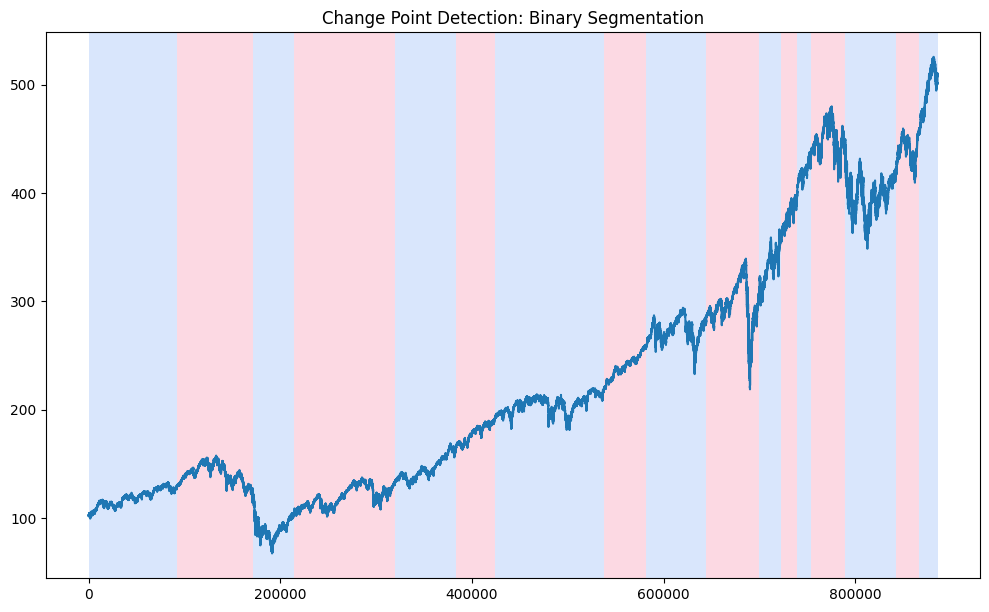

In [ ]:
import ruptures as rpt
import matplotlib.pyplot as plt

# detection
algo = rpt.Binseg(model="l2").fit(df['close'].values)
result = algo.predict(n_bkps=16)

# display
rpt.display(df['close'].values, result, figsize=(10, 6))
plt.title('Change Point Detection: Binary Segmentation')
plt.show()

In [ ]:
import ruptures as rpt
# detection
algo = rpt.Pelt(model="l2").fit(df['close'].values)
result = algo.predict(pen=1)

# display
rpt.display(df['close'].values, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()

In [ ]:
def cusum_events(df: pd.DataFrame,
                 h: float=None,
                 span: int=100,
                 devs: float=2.5) -> pd.DataFrame:
    '''
    Compute CUSUM events for a given price series.
    Args:
    df (pd.DataFrame): Dataframe with price time series
    in a single column.
    h (float): Arbitrary cumulative returns value limit to trigger
    the CUSUM filter.
    The filter is symmetric.
    If h is None exponentially weighted standard deviation will
    be used.
    span (int): Span for exponential weighting of standard deviation.
    devs (float): Standard deviations to compute variable
    trigger limits if h is not defined.
    Returns:
    pd.DataFrame: Dataframe containing differentiated series.
    '''
    # Events e:
    e = pd.DataFrame(0, index=df.index,
                     columns=['CUSUM_Event'])
    s_pos = 0
    s_neg = 0
    r = df.pct_change()

    for idx in r.index:
        if h is None:
            h_ = r[:idx].ewm(span=span).std().values[-1][0]*devs
        else: h_ = h
        s_pos = max(0, s_pos+r.loc[idx].values)
        s_neg = min(0, s_neg+r.loc[idx].values)
        if s_neg < -h_:
            s_neg = 0
            e.loc[idx] = -1
        elif s_pos > h_:
            s_pos = 0
            e.loc[idx] = 1
    return e

In [ ]:
results = cusum_events(df[['close']],devs=100)
results